In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array

import warnings
warnings.filterwarnings('ignore')

In [31]:
data = pd.read_csv('hotel_bookings.csv')
df = data.loc[:5000, ['hotel', 'is_canceled', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 
               'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests']]

In [32]:
df.head()

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1


# Data Cleaning & Pre-processing

## Checking Missing Values

In [34]:
df.isna().sum()

hotel                          0
is_canceled                    0
adults                         0
children                       0
babies                         0
meal                           0
country                        2
market_segment                 0
distribution_channel           0
reserved_room_type             0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
required_car_parking_spaces    0
total_of_special_requests      0
dtype: int64

In [35]:
df[df['country'].isna()]

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
30,Resort Hotel,0,1,0.0,0,BB,NaN,Direct,Direct,A,2,No Deposit,0,Transient,0,2
4127,Resort Hotel,1,0,0.0,0,SC,NaN,Offline TA/TO,TA/TO,P,0,No Deposit,0,Transient,0,0


Terdapat missing value di kolom `country` sebanyak 2 row. Menurut saya bisa di drop karena jumlahnya sangat amat sedikit dari total data dan setelah di cek tidak ada kolom yang bisa menjadi patokan. Pertimbangannya ketimbang diisi dan menjadi distorsi pada data makanya saya drop

In [36]:
df.dropna(inplace=True)
df.isna().sum()

hotel                          0
is_canceled                    0
adults                         0
children                       0
babies                         0
meal                           0
country                        0
market_segment                 0
distribution_channel           0
reserved_room_type             0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
required_car_parking_spaces    0
total_of_special_requests      0
dtype: int64

In [37]:
df.head()

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1


## Checking data-type for every column

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 5000
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        4999 non-null   object 
 1   is_canceled                  4999 non-null   int64  
 2   adults                       4999 non-null   int64  
 3   children                     4999 non-null   float64
 4   babies                       4999 non-null   int64  
 5   meal                         4999 non-null   object 
 6   country                      4999 non-null   object 
 7   market_segment               4999 non-null   object 
 8   distribution_channel         4999 non-null   object 
 9   reserved_room_type           4999 non-null   object 
 10  booking_changes              4999 non-null   int64  
 11  deposit_type                 4999 non-null   object 
 12  days_in_waiting_list         4999 non-null   int64  
 13  customer_type     

---

# EDA

In [220]:
df_eda = pd.read_csv('hotel_bookings.csv')
df_eda = df_eda.loc[:5000, ['hotel', 'is_canceled', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 
               'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests']]
df_eda.dropna(inplace=True)

Saya mau merubah semua yang 0 menjadi tidak cancel dan 1 menjadi cancel agar visualisasi lebih baik

In [221]:
def cancelled(x):
    if x == 0:
        return('Not Cancel')
    if x == 1:
        return('Cancel')
df_eda['is_canceled'] = df_eda['is_canceled'].apply(lambda x: cancelled(x))

## Checking target column (`is_canceled`)

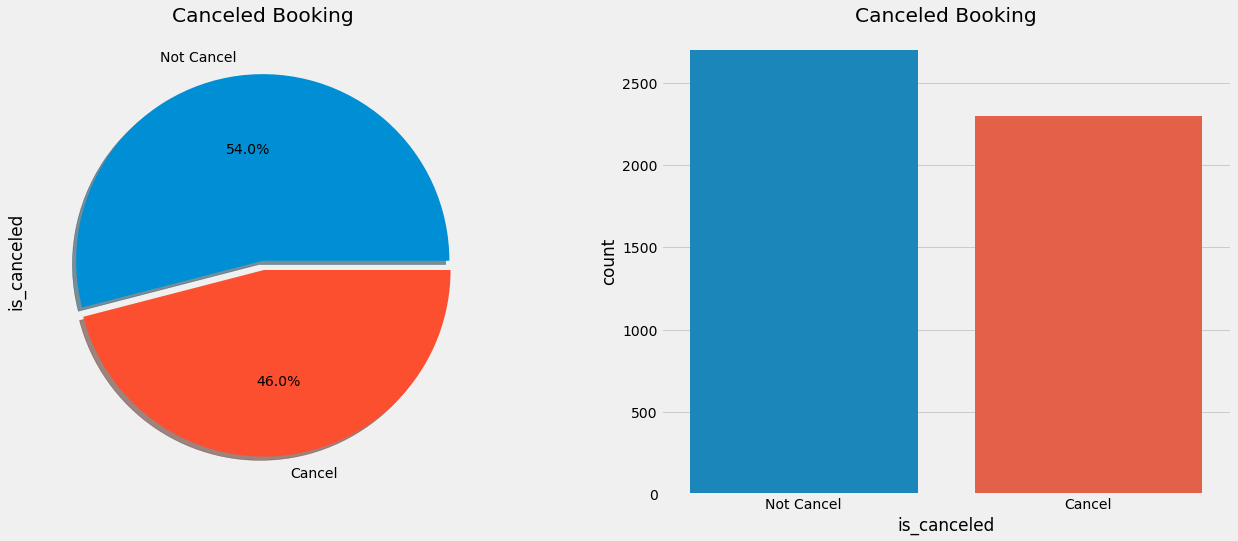

In [222]:
fig,ax=plt.subplots(1,2,figsize=(20,8))
df_eda['is_canceled'].value_counts().plot.pie(explode=[0,0.05],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Canceled Booking')
sns.countplot('is_canceled',data=df_eda,ax=ax[1],order=df_eda['is_canceled'].value_counts().index)
ax[1].set_title('Canceled Booking')
plt.show()

Terdapat 46% pemesanan hotel yang dicancel yaitu sebanyak 2298 pemesanan 

## Cek Paling banyak yang cancel dari negara mana

In [223]:
df_cancel = df_eda[df_eda['is_canceled'] == 'Not Cancel']
df_cancel.head()

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,Not Cancel,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,Not Cancel,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,Not Cancel,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,Not Cancel,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,Not Cancel,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1


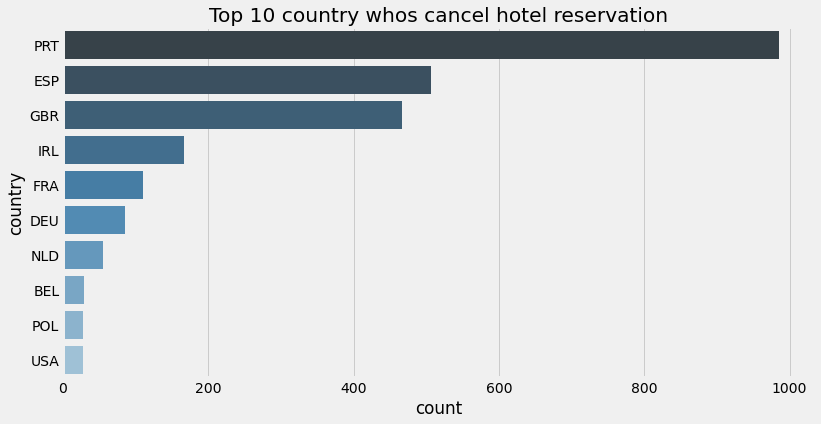

In [224]:
top_10_country_cancel = pd.DataFrame(df_cancel['country'].value_counts().head(10))
plt.figure(figsize=(12,6))
sns.countplot(data=df_cancel, y='country', order=top_10_country_cancel.index, palette="Blues_d")
plt.title('Top 10 country whos cancel hotel reservation')
plt.show()

Paling banyak cancel dari PRT yaitu Portugal, kemudian Spain, dan GBR (United Kingdom)

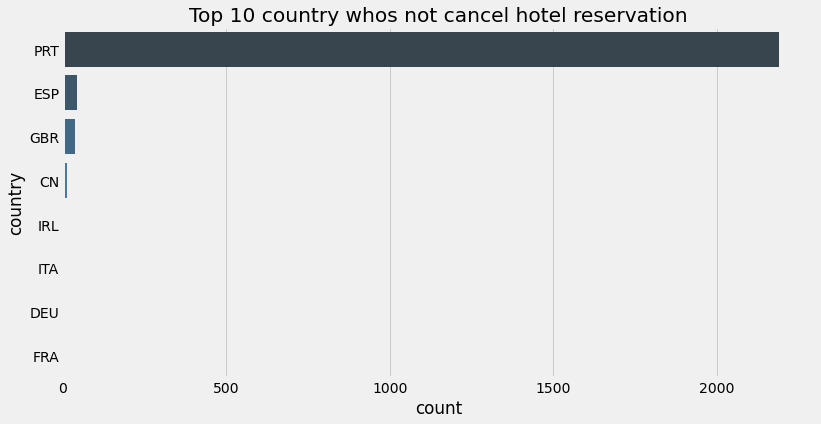

In [226]:
df_not_cancel = df_eda[df_eda['is_canceled'] == 'Cancel']
top_10_country_notcancel = pd.DataFrame(df_not_cancel['country'].value_counts().head(10))
plt.figure(figsize=(12,6))
sns.countplot(data=df_not_cancel, y='country', order=top_10_country_notcancel.index, palette="Blues_d")
plt.title('Top 10 country whos not cancel hotel reservation')
plt.show()

Negara yang paling banyak tidak melakukan cancellation juga ternyata dari Portugal

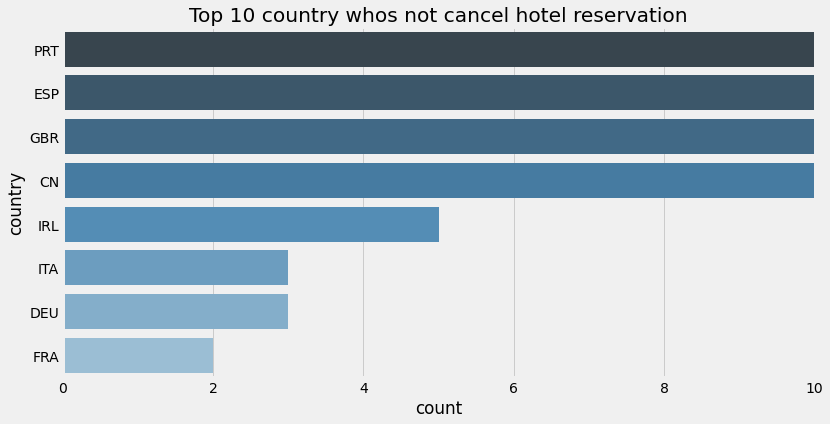

In [227]:
df_not_cancel = df_eda[df_eda['is_canceled'] == 'Cancel']
top_10_country_notcancel = pd.DataFrame(df_not_cancel['country'].value_counts().head(10))
plt.figure(figsize=(12,6))
sns.countplot(data=df_not_cancel, y='country', order=top_10_country_notcancel.index, palette="Blues_d")
plt.title('Top 10 country whos not cancel hotel reservation')
plt.xlim([0,10])
plt.show()

In [228]:
df_eda['country'].value_counts().head(15)

PRT    3175
ESP     550
GBR     505
IRL     172
FRA     113
DEU      89
NLD      55
CN       33
BEL      29
POL      28
USA      28
CHE      26
ITA      23
RUS      23
BRA      18
Name: country, dtype: int64

Sepertinya dataset ini tidak balance di bagian country karena timplang sekali observasi di negara Portugal sehingga yang paling banyak cancel dan tidak cancel keduanya berasal dari negara Portugal

## Cek paling banyak yang reservasi hotel terdiri dari berapa orang dewasa

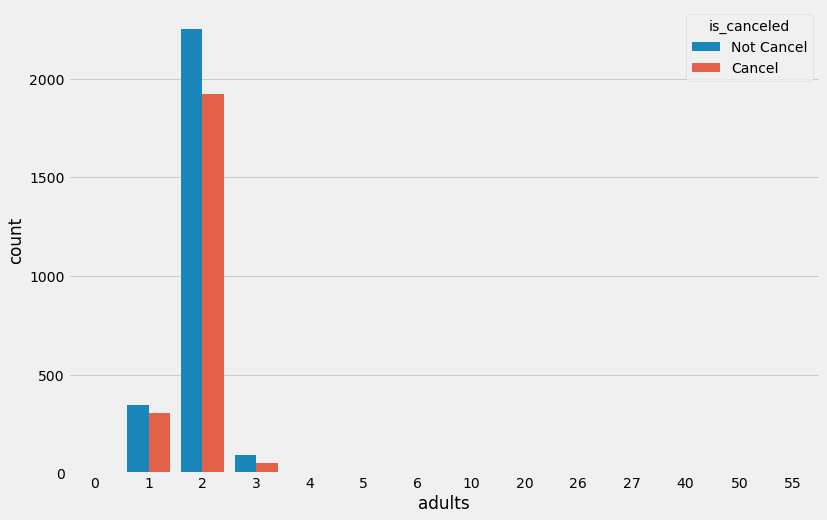

In [229]:
plt.figure(figsize=(12,8))
sns.countplot(x='adults', data=df_eda, hue='is_canceled');

Paling banyak 2 orang dewasa, diikuti dengan 1 orang dewasa, dan 3 orang dewasa. 

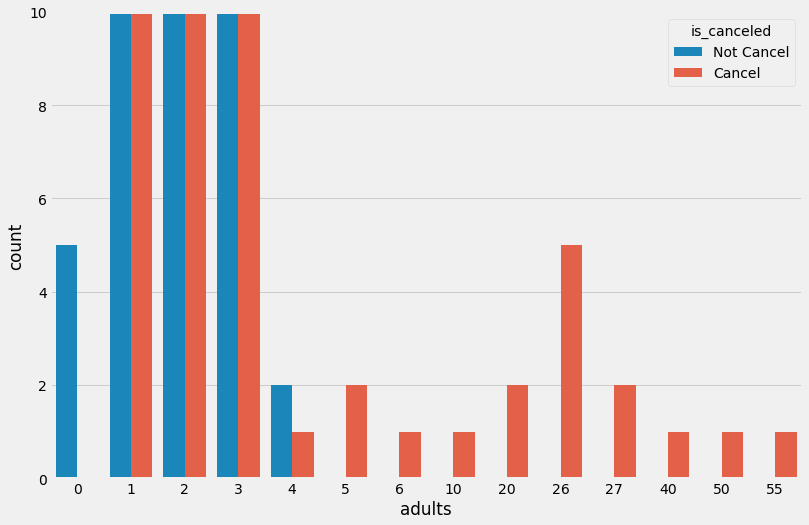

In [230]:
plt.figure(figsize=(12,8))
sns.countplot(x='adults', data=df_eda, hue='is_canceled')
plt.ylim([0, 10]);

Semua orang dewasa yang boking diatas 4 orang melakukan cancellation dan yang tidak ada orang dewasa sama sekali justru semuanya tidak ada yang cancel

## Berapa banyak dari semua yang reservasi hotel yang membawa anak-anak

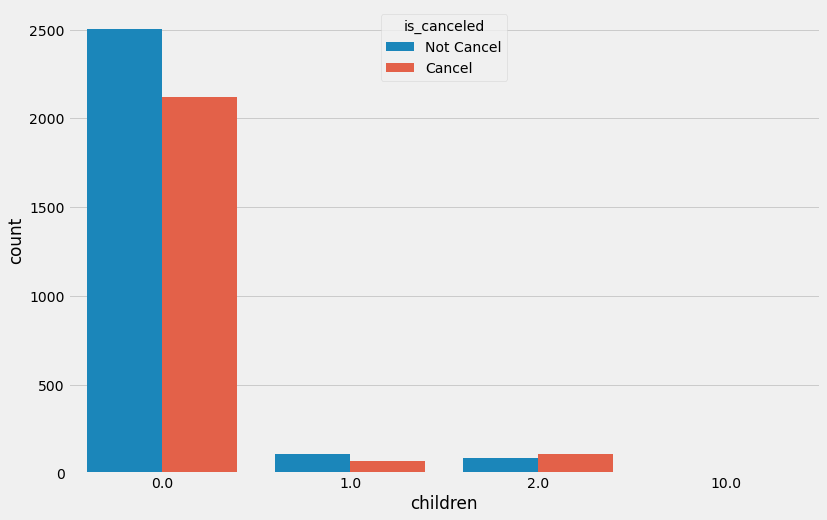

In [231]:
plt.figure(figsize=(12,8))
sns.countplot(x='children', data=df_eda, hue='is_canceled');

Customer yang melakukan reservasi paling banyak tidak membawa anak sama sekali diikuti dengan 1 orang anak dan 2 orang anak

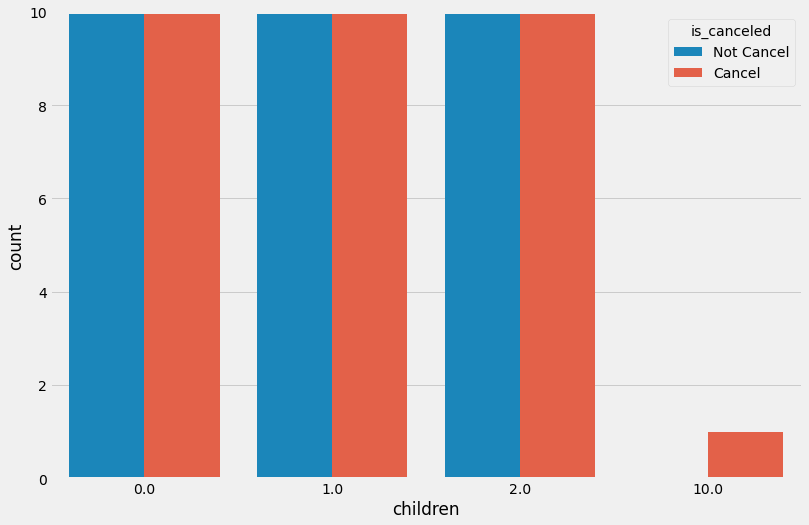

In [232]:
plt.figure(figsize=(12,8))
sns.countplot(x='children', data=df_eda, hue='is_canceled')
plt.ylim([0,10]);

Semua booking yang membawa lebih dari 2 orang anak melakukan cancellation

## Berapa customer yang membawa anak bayi

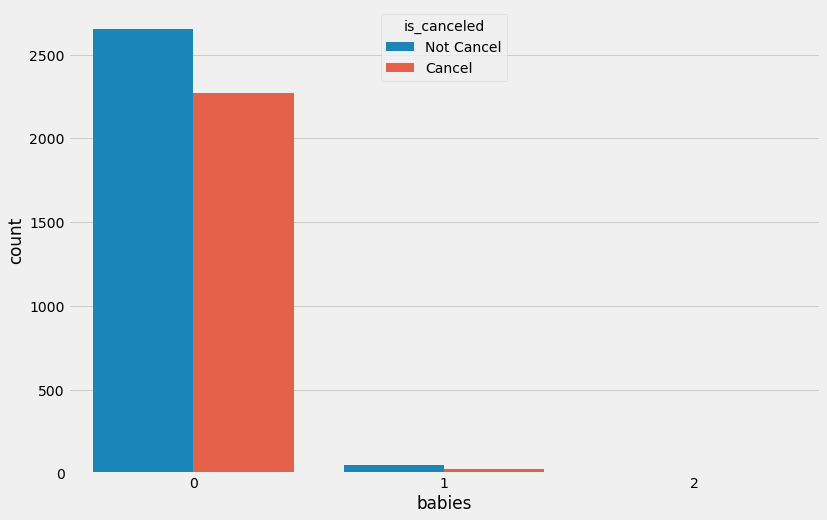

In [233]:
plt.figure(figsize=(12,8))
sns.countplot(x='babies', data=df_eda, hue='is_canceled');

Hampir semua orang yang reservasi hotel tidak membawa anak bayi

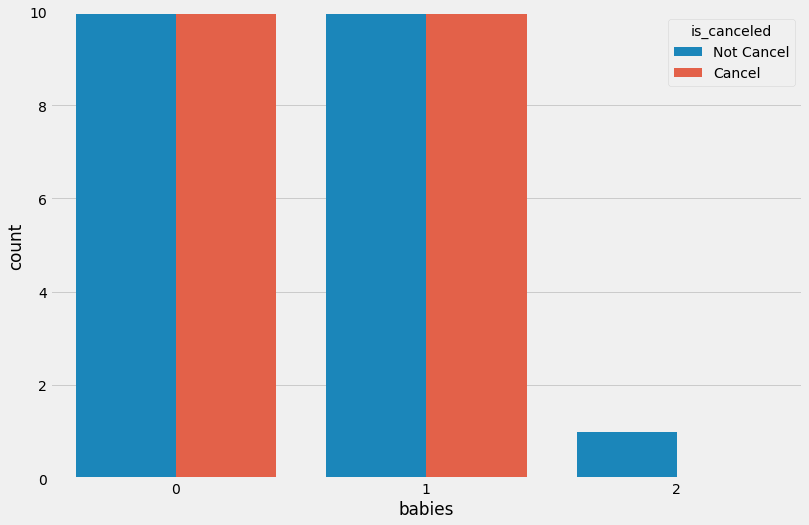

In [234]:
plt.figure(figsize=(12,8))
sns.countplot(x='babies', data=df_eda, hue='is_canceled')
plt.ylim([0, 10]);

Semua reservasi yang membawa anak bayi lebih dari 1 tidak ada yang di cancel

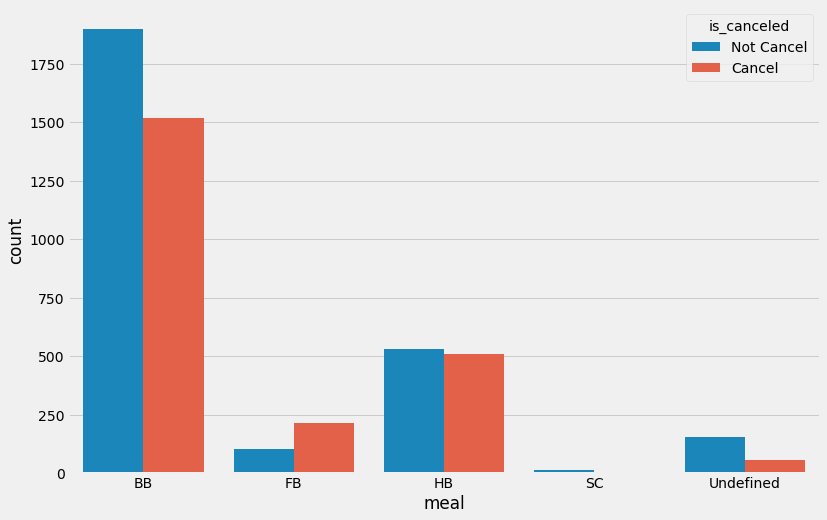

In [235]:
plt.figure(figsize=(12,8))
sns.countplot(x='meal', data=df_eda, hue='is_canceled');

Dari jenis meal, customer yang paling banyak melakukan reservasi adalah BB – Bed & Breakfast, diikuti HB – Half board (breakfast and one other meal – usually dinner). Dari jenis meal, yang banyak melakukan cancellation adalah BB, HB, diikutin FB – Full board (breakfast, lunch and dinner)

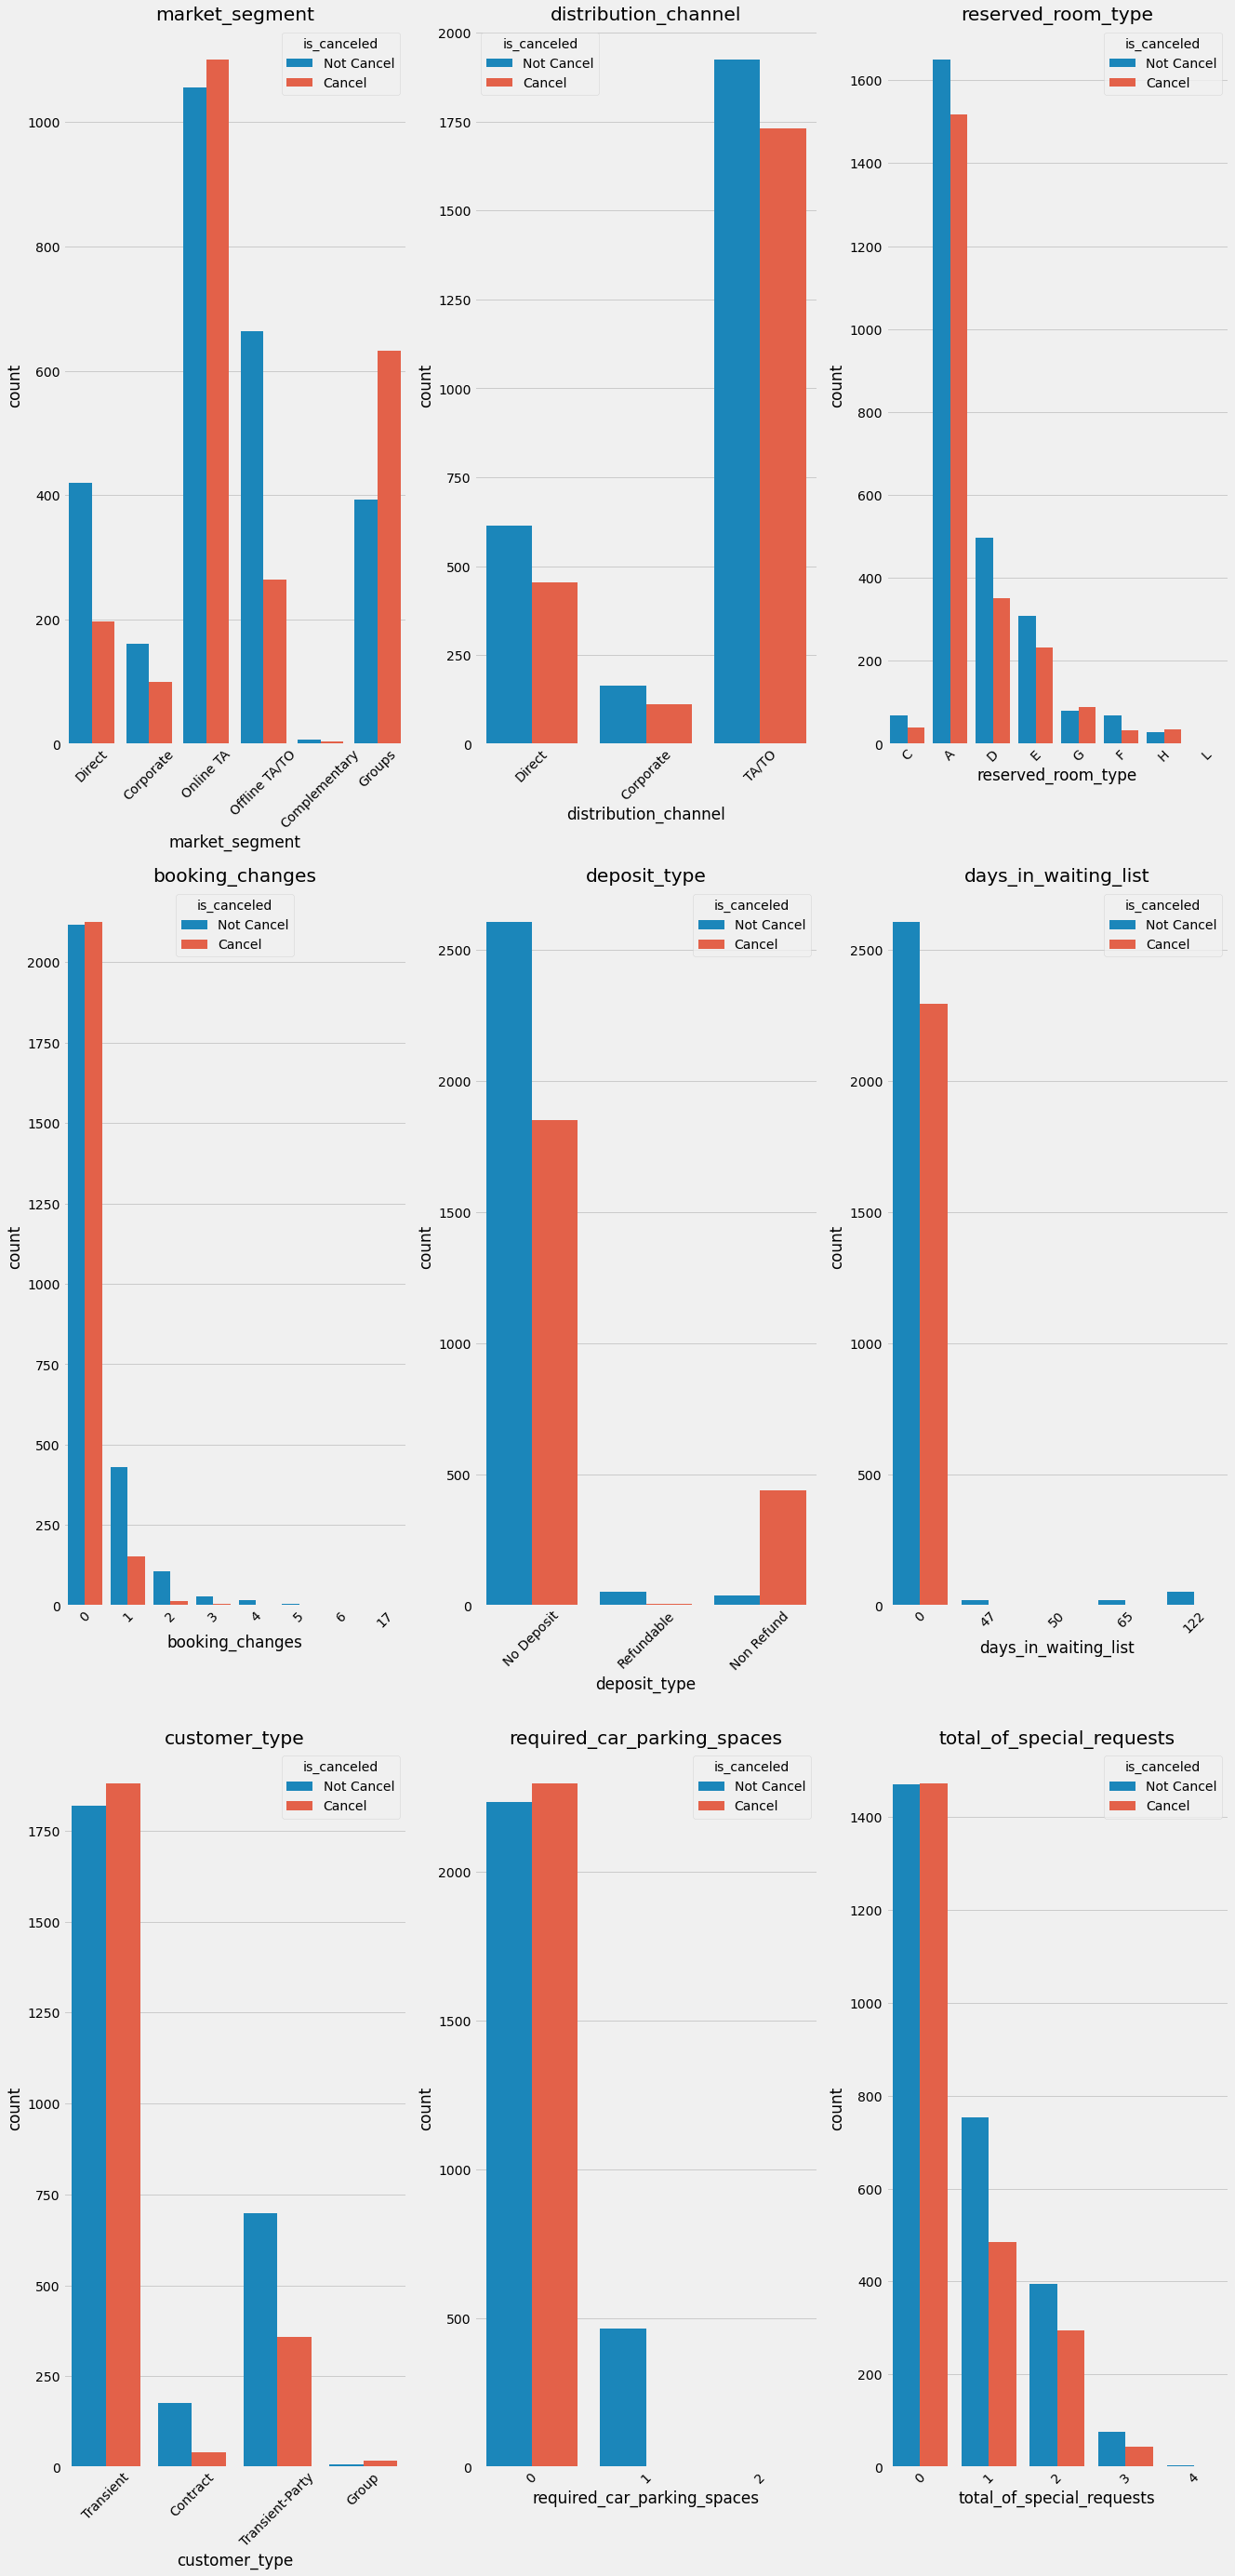

In [243]:
n = 1
plt.figure(figsize=(20,45))
for i in ['market_segment', 'distribution_channel', 'reserved_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 
          'required_car_parking_spaces', 'total_of_special_requests']:
    plt.subplot(3, 3, n)
    sns.countplot(x=i, data=df_eda, hue='is_canceled')
    plt.title(i)
    plt.xticks(rotation=45)
    n+=1
    
plt.show()
    

## Whole Busineness Insight

- Terdapat 46% pemesanan hotel yang dicancel yaitu sebanyak 2298 pemesanan
- Paling banyak cancel dari PRT yaitu Portugal, kemudian Spain, dan GBR (United Kingdom), negara yang paling banyak tidak melakukan cancellation juga ternyata dari Portugal, sepertinya dataset ini tidak balance di bagian country karena timplang sekali observasi di negara Portugal sehingga yang paling banyak cancel dan tidak cancel keduanya berasal dari negara Portugal
- Paling banyak 2 orang dewasa, diikuti dengan 1 orang dewasa, dan 3 orang dewasa, semua orang dewasa yang boking diatas 4 orang melakukan cancellation dan yang tidak ada orang dewasa sama sekali justru semuanya tidak ada yang cancel
- Customer yang melakukan reservasi paling banyak tidak membawa anak sama sekali diikuti dengan 1 orang anak dan 2 orang anak, semua booking yang membawa lebih dari 2 orang anak melakukan cancellation
- Hampir semua orang yang reservasi hotel tidak membawa anak bayi, semua reservasi yang membawa anak bayi lebih dari 1 tidak ada yang di cancel


---

- Kebanyak reservasi memiliki market segment dari Online Travel Agent, dan ini juga yang memiliki probability cancellation yang lebih tinggi
- Hampir semua reservasi menggunakan distribution channel melalui Travel Agent dan Tour Operators 
- Kebanyakan reservasi memilih tipe room A kemudian diikuti D, dan E

---

- Hampir semua reservasi tidak mengalami perubahan (0), kemudian diikuti dengan 1x perubahaan dan seterusnya. Reservasi yang tidak mengalami perubahan justru memiliki persentase cancel yang lebih besar ketimbang dilakukan perubahaan reservasi
- Kebanyakan reservasi tidak menggunakan deposit. Disini anehnya justru deposit yang Non-Refundable memiliki persentase yang lebih banyak di-cancel ketimbang tidak memiliki deposit.
- Hampir semua booking tidak perlu menunggu waiting list. Semua booking yang terkena waiting list persentase tidak dicancelnya semua lebih besar. Artinya customer yang bela-belain nunggu waiting-list booking justru lebih niat (karena tidak cancel booking)

---

- Hampir seluruh tipe customer yang booking hotel adalah Transient (when the booking is not part of a group or contract, and is not associated to other transient booking). Persentasi cancel yang paling besar berasal dari tipe ini dan Group (when the booking is associated to a group)
- Hampir seluruh customer yang reservasi hotel tidak membutuhkan tempat parkir, namun persentase yang cancel lebih tinggi grup ini. Customer yang membutuhkan tempat parkir sebanyak 1 persentase tidak cancel bookingnya ternyata lebih besar
- Kebanyakan customer yang melakukan reservasi tidak meminta special_request. Namun persentase cancel booking dari grup ini slightly lebih besar daripada persentase yang tidak cancel booking. Semua customer yang meminta special_request persentase tidak dicancelnya reservasi lebih besar

---

# Model Building & Hyper-parameter Tuning

In [61]:
df.drop(columns='hotel', inplace=True)

Kolom hotel di drop karena isinya hanya nama hotel dan tidak dimasukkan kedalam machine learning

## Merubah semua categorical feature menjadi numerical dengan label encoder

In [65]:
df['meal'] = LabelEncoder().fit_transform(df['meal'])
df['country'] = LabelEncoder().fit_transform(df['country'])
df['market_segment'] = LabelEncoder().fit_transform(df['market_segment'])
df['distribution_channel'] = LabelEncoder().fit_transform(df['distribution_channel'])
df['distribution_channel'] = LabelEncoder().fit_transform(df['distribution_channel'])
df['reserved_room_type'] = LabelEncoder().fit_transform(df['reserved_room_type'])
df['deposit_type'] = LabelEncoder().fit_transform(df['deposit_type'])
df['customer_type'] = LabelEncoder().fit_transform(df['customer_type'])
df.head()

,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,0,2,0.0,0,0,43,2,1,1,3,0,0,2,0,0
1,0,2,0.0,0,0,43,2,1,1,4,0,0,2,0,0
2,0,1,0.0,0,0,24,2,1,0,0,0,0,2,0,0
3,0,1,0.0,0,0,24,1,0,0,0,0,0,2,0,0
4,0,2,0.0,0,0,24,5,2,0,0,0,0,2,0,1


Saya menggunakan labelencoder karena datanya categorical yang tidak bersifat ordinal sehingga bisa dilakukan cara seperti ini

## Split Dataset and Modelling Also Evaluating

In [97]:
x = df.drop(columns='is_canceled')
y = df['is_canceled']

In [98]:
# Split train data 80%, test data 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Menggunakan RobustScaler biar lebih bagus ke machine learningnya dan karena banyak outlier juga
x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

# Model
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
decision_tree = DecisionTreeClassifier()

LogisticRegression()
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       497
           1       0.80      0.87      0.84       503

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



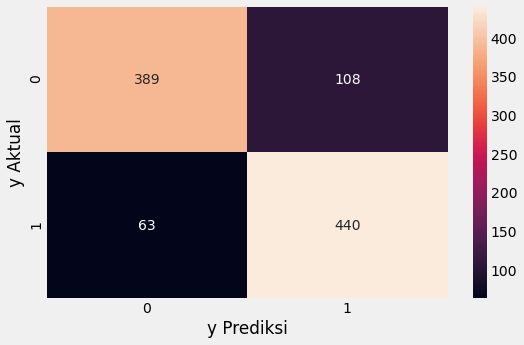

tn = 389 fp = 108 fn = 63 tp = 440




RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       497
           1       0.86      0.89      0.88       503

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



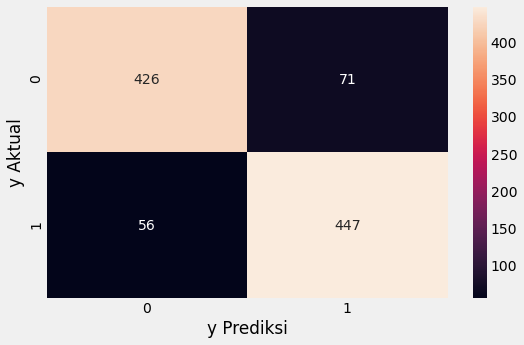

tn = 426 fp = 71 fn = 56 tp = 447




DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       497
           1       0.86      0.87      0.87       503

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000



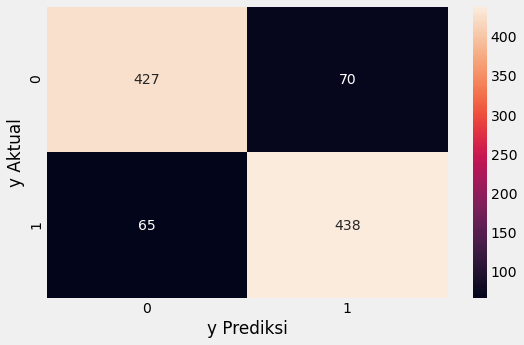

tn = 427 fp = 70 fn = 65 tp = 438






In [117]:
for model in [logistic_regression, random_forest, decision_tree]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(model)
    print(classification_report(y_test, y_pred))
    f, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
    plt.xlabel('y Prediksi')
    plt.ylabel('y Aktual')
    plt.show()
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('tn =', tn, 'fp =', fp, "fn =", fn, "tp =", tp)
    print('\n')
    print('\n')
    

Dari classification_report diatas dapat dilihat bahwa model RandomForestClassifier memiliki persentasi yang lebih besar baik dari precision +/-, recall +/-, f1_score +/-, dan accuray_score. Hal ini menjadikan model RandomForest menjadi model yang paling baik diantara lainnya

**Penjelasan Model**

**Logistic Regression** is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.'

Dari penjelasan ini menjadikan saya menggunakan logistic regression karena target yang ditentukan sifatnya kategorikal yaitu cancel booking/not

**Decision Tree** algorithm belongs to the family of supervised learning algorithms. Unlike other supervised learning algorithms, the decision tree algorithm can be used for solving regression and classification problems too.

The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from prior data(training data).

In Decision Trees, for predicting a class label for a record we start from the root of the tree. We compare the values of the root attribute with the record’s attribute. On the basis of comparison, we follow the branch corresponding to that value and jump to the next node.

Jadi seperti memberikan pertanyaan dari feature yang paling menentukan terlebih dahulu kemudian ke pertanyaan-pertanyaan selanjutnya hingga terdapat klasifikasi dari pertanyaan tersebut. Root ditentukan berdasarkan entropy

**Random forest**, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

RandomForest seperti DecisionTree tapi jumlahnya banyak dan diambil secara random. Konsep fundamentalnya : The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds. In data science speak, the reason that the random forest model works so well is:
A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models

## Tuning Parameter

Pertama saya nge-set parameter apa saja yang akan di tuning dari setiap model

In [105]:
# LogisticRegression Parameter
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [1, 10, 100, 1000, 10000]

param_logistic = {'penalty':penalty, 'solver':solver, 'max_iter':max_iter}

In [106]:
# RandomForest Parameter
max_depth=[10,20,30,40,50,60,70,80,90,100]
min_samples_leaf= [1, 2, 4]
min_samples_split= [2, 5, 10]
n_estimators=[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

param_randomf = {'max_depth':max_depth,'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split,'n_estimators':n_estimators}

In [107]:
# DecisionTree Parameter
criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth=[10,20,30,40,50,60,70,80,90,100]
min_samples_split= [2, 5, 10]
min_samples_leaf= [1, 2, 4]

param_decisiont = {'criterion' : criterion, 'splitter' : splitter, 'max_depth':max_depth,'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split}

---

Kemudian saya menggunakan RandomSearchCV dengan secara random mencari parameter yang terbaik. Sebenarnya ini bukan best practice, best practicenya menggunakan GridSearchCV hanya saja karena komputasional yang lama dan keterbatasan waktu saat ujian makanya saya menggunakan RandomSearchCV

In [111]:
all_model = [logistic_regression, random_forest, decision_tree]
all_parameter = [param_logistic, param_randomf, param_decisiont]
for i in range(len(all_model)):
    model_tuned = RandomizedSearchCV(estimator=all_model[i], param_distributions=all_parameter[i], cv=5)
    model_tuned.fit(x_train, y_train)
    print("model =", all_model[i])
    print(model_tuned.best_params_)
    print('\n')
    

model = LogisticRegression()
{'solver': 'sag', 'penalty': 'l2', 'max_iter': 100}


model = RandomForestClassifier()
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}


model = DecisionTreeClassifier()
{'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'}




In [112]:
logistic_regression_tuned = LogisticRegression(solver='sag', penalty='l2', max_iter=100)
random_forest_tuned = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=20)
decision_tree_tuned = DecisionTreeClassifier(splitter='best', min_samples_split=5, min_samples_leaf=2, max_depth=20, criterion='entropy')

LogisticRegression(solver='sag')
              precision    recall  f1-score   support

           0       0.85      0.76      0.81       497
           1       0.79      0.87      0.83       503

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



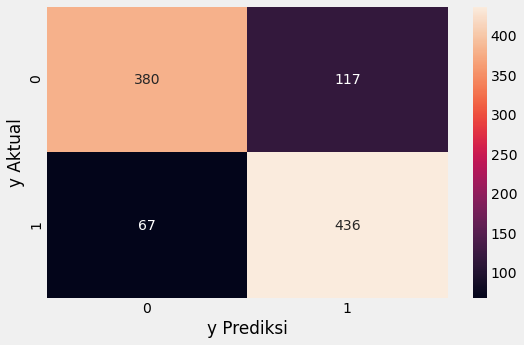

tn = 380 fp = 117 fn = 67 tp = 436




RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=1000)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       497
           1       0.86      0.89      0.87       503

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



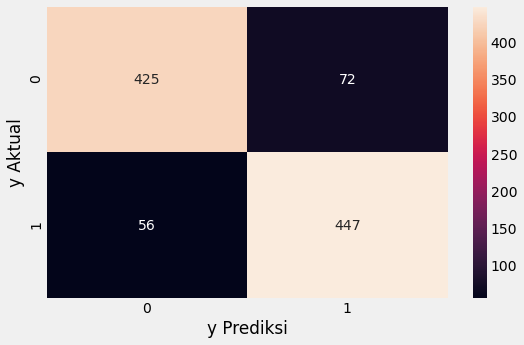

tn = 425 fp = 72 fn = 56 tp = 447




DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=5)
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       497
           1       0.86      0.86      0.86       503

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



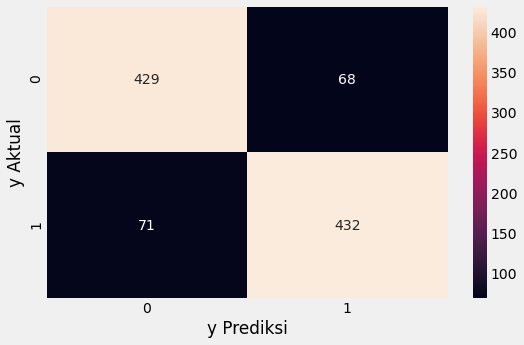

tn = 429 fp = 68 fn = 71 tp = 432






In [116]:
for model in [logistic_regression_tuned, random_forest_tuned, decision_tree_tuned]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(model)
    print(classification_report(y_test, y_pred))
    f, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
    plt.xlabel('y Prediksi')
    plt.ylabel('y Aktual')
    plt.show()
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('tn =', tn, 'fp =', fp, "fn =", fn, "tp =", tp)
    print('\n')
    print('\n')

# Kesimpulan dan Model Evaluasi

Disini diartikan bahwa nilai 0 berarti tidak melakukan cancel dan nilai 1 melakukan cancelation, kemudian positif = cancel, dan negatif = tidak cancel

Pertanyaan :
1. Pilih jenis kesalahan yang paling berpengaruh pada kerugian finansial perusahaan dan jelaskan alasan pilihan Anda!
2. Pilih dan berikan alasan evaluation metric yang bisa menekan jenis kesalahan yang Anda pilih!
3. Jelaskan langkah Anda untuk meningkatkan performa model ML untuk bisa menekan jenis kesalahan tersebut!

Jawaban :
1. Jenis kesalahan yang paling berpengaruh adalah apabila diprediksi dia tidak cancel booking tapi ternyata aktualnya cancel booking. Dalam hal ini berarti diprediksi 0 tapi aktual-nya 1 karena ketika diprediksi 0 (tidak cancel) tapi ternyata aktualnya 1 (cancel) perusahaan tidak mendapatkan revenue dari customer sehingga otomatis akan mengurangi pendapatan dari perusahaan tersebut. Selain dari sisi financial perusahaan juga rugi dalam hal usaha yang dilakukan untuk customer yang diprediksi tidak cancel. Udah capek-capek menyiapkan beberapa hal yang disebutkan di soal namun ternyata customernya cancel jadi sia sia juga. Jadi kesalahan yang paling berpengaruh terhadap finansial perusahaan adalah : **Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user cancel booking (membatalkan pesanan).**

2. Dari evaluation metric berarti nilai yang harus diantisipasi adalah yang diprediksi 0 (tidak cancel) tapi aktualnya 1 (cancel) yaitu fn(false negative) karena dengan menekan angka ini, perusahaan dapat mengurangi kerugian yang dapat diterima baik dari segi financial ataupun management terhadap customer

3. Langkah yang akan saya lakukan untuk meningkatkan performa model adalah **meningkatkan precision negative score** atau **meningkatkan recall positive score**. Dari **precision score negative** artinya meningkatkan persentase dari prediksi yang dianggap tidak cancel booking sehingga jumlah dari customer yang diprediksi tidak cancel booking tapi ternyata cancel akan menurun. Dari **recall positive score** artinya meningkatkan persentasi kondisi aktual dari costumer yang tidak cancel booking sehingga otomatis customer yang cancel booking akan menurun

Precision Negative = tn/tn+fn

Recall Positive = tp/tp+fn

Conclusion : **Dari semua model yang dicoba, saya tetap akan menggunakan RandomForest karena nilai Precision Negative (0.88) yang tinggi dan Recall Positive yang tinggi juga (0.89) dibanding dengan kedua model lainnya dan nilai false negative yang paling rendah (56) juga diantara ketiga model**